In [57]:
import datetime
import ee
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import os
import geopandas as gp

ee.Initialize()

In [58]:
def init():
    
    '''
    Set the init params:
    1) Area
    2) Satellite 
    3) Years to analyze 
    
    '''
    
    ##### AREA #####

    # County 
    area = (ee.FeatureCollection('ft:1FEPBzXYqUbdWXG2wTFOyb-ts9_GbeI5NFraMq2yk').filter(ee.Filter().eq('COUNTY num', 95)))
    
    # Central Valley
    area = ee.FeatureCollection('ft:1h46ENpEp8vO3pOe1EqeF1sZLEDhSVMxbu8pHAoU4', 'geometry')
        
    # Whole state:
    area = (ee.FeatureCollection('ft:1fRY18cjsHzDgGiJiS2nnpUU3v9JPDc2HNaR7Xk8').filter(ee.Filter().eq('Name', 'California')))
    
    # HUC 4s draining to the CV 
    cv = gp.read_file("../shape/cv_hu6.shp")
    lls = cv.geometry.iloc[0]
    x,y = lls.exterior.coords.xy
    coords = [list(zip(x,y))]
    
    area = ee.Geometry.Polygon(coords)
        
    ###### SATELLITES ######
    
    modis = ee.ImageCollection('MODIS/006/MOD16A2')
    
    ##### TIME RANGE #####
    years = [x for x in range(2001, 2016)]
    
    return [[modis],area,years]
    

def retrieve(satellite):
    if satellite == ee.ImageCollection('MODIS/006/MOD16A2'):
        var = "ET"
    return var

In [91]:
def filter_date(product,year):
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,1,1)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select(retrieve(product))
    return prod
    
def aggregate_precip(product,year):
    
    # Select appropriate resolution from product. Set lower if you exceed the google request
    if product == ee.ImageCollection('MODIS/006/MOD16A2'):
        res = 2500

    # Filter
    filtered = filter_date(product, year)

    # calculate the monthly mean
    def calc_sum(imageCollection,year):
        mylist = ee.List([])
        months = range(1,13)
        for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum();
                mylist = mylist.add(w.set('year', year).set('month', m).set('date', ee.Date.fromYMD(year,m,1)).set('system:time_start',ee.Date.fromYMD(year,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    monthly = ee.ImageCollection(calc_sum(filtered, year))

    # select the region of interest, res is the cellsize in meters
    monthly = monthly.getRegion(area,res,"epsg:4326").getInfo()

    return monthly 

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable, month):
    df = df[df.id == str(month)] 
    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

In [92]:
def main(years, product):
    finals = []
    for year in years:
        finals.append(aggregate_precip(product,year))
    
    dfs = []
    for i in finals:
        dfs.append(df_from_ee_object(i))
    
    months = [int(x) for x in dfs[0].id.unique()]
    
    yearly = []
    for i in dfs:
        result = []
        for m in months:
            monthly = []
            a = array_from_df(i,retrieve(product),m)
            result.append(a)
        yearly.append(result)
        
    yearly_arrays = [np.array(x) for x in yearly]
    timeseries = [np.array(x) for x in yearly_arrays]
    all_data = [item for sublist in timeseries for item in sublist]
    final = np.dstack(all_data)
    final = np.ma.masked_where(final == 0, final)
    dist = final[np.logical_not(np.isnan(final))]
    
    return final

In [93]:
sats, area, years = init()

In [94]:
modis = main(years, sats[0])

/Users/aakashahamed/anaconda3/envs/gisanimation/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


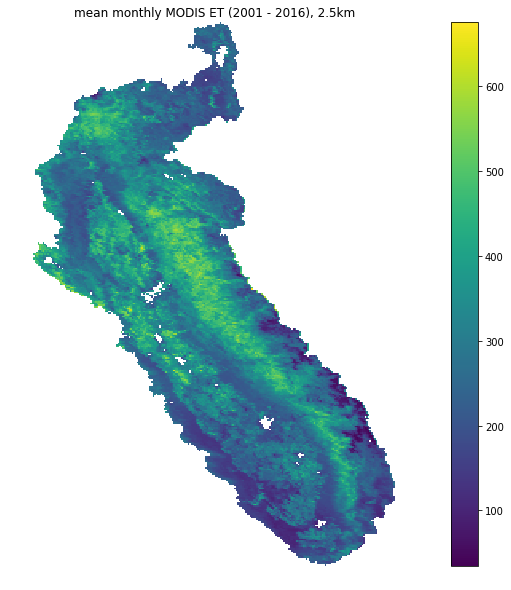

In [95]:
plt.figure(figsize=(20,10))

plt.title("mean monthly MODIS ET (2001 - 2016), 2.5km")

plt.imshow(np.nanmean(modis, axis = 2),cmap = plt.get_cmap("viridis")) 
plt.colorbar()
plt.axis('off')

plt.show()

/Users/aakashahamed/anaconda3/envs/gisanimation/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


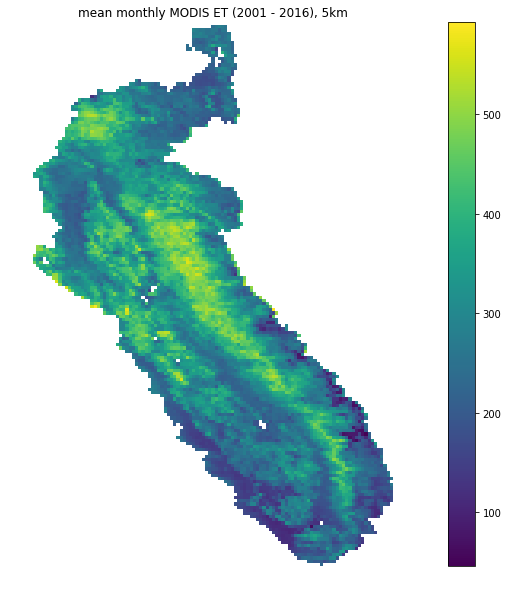

In [90]:
plt.figure(figsize=(20,10))

plt.title("mean monthly MODIS ET (2001 - 2016), 5km")

plt.imshow(np.nanmean(modis, axis = 2),cmap = plt.get_cmap("viridis")) 
plt.colorbar()
plt.axis('off')

plt.show()